
# Trabalho Curso de Verão

### Escola de Matemática Aplicada - EMAP

### Aluno: Igor Sales

#### Importando os Pacotes Necessários


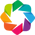

In [2]:
import matplotlib
import poloniex
import datetime
import sqlite3 
import holoviews as hv
import pandas as pd
import numpy as np
import warnings
import pickle
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')
hv.Dimension.type_formatters[np.datetime64] = '%m/%y'


#### Moedas

In [5]:
moeda_1='USDT_XRP'
moeda_2='USDT_NXT'

#### Importando os dados

In [7]:
final_serie = datetime.datetime.now()
começo_serie = final_serie - datetime.timedelta(days=365)
dados_XRP = poloniex.get_ohlc(moeda_1, começo_serie,final_serie) 
dados_NXT= poloniex.get_ohlc(moeda_2, começo_serie,final_serie)

#### Estatística Descritiva

In [8]:
est_XRP=dados_XRP.describe()
est_NXT=dados_NXT.describe()

#### Criando  e salvado os dados no diretório

In [10]:
conexao_diretorio= create_engine('sqlite:///dados.sqlite') 
dados_NXT.to_sql('poloniex_USDT_NXT', conexao_diretorio,if_exists='replace')
dados_XRP.to_sql('poloniex_USDT_XRP', conexao_diretorio,if_exists='replace')

In [11]:
conexao_diretorio.table_names()

['poloniex_USDT_NXT', 'poloniex_USDT_XRP']

In [ ]:
#### trazendo os dados do diretório

In [12]:
banco_NXT= pd.read_sql('poloniex_USDT_NXT', conexao_diretorio)
banco_XRP = pd.read_sql('poloniex_USDT_XRP', conexao_diretorio)
banco_NXT.set_index(['date'],inplace=True)
banco_XRP.set_index(['date'],inplace=True)

In [13]:
banco_NXT.head()

close      high       low      open  quoteVolume  \
date                                                                       
2017-02-02 20:55:00  0.006327  0.006327  0.006327  0.006327     0.000000   
2017-02-02 21:00:00  0.006341  0.006341  0.006341  0.006341    63.815947   
2017-02-02 21:05:00  0.006341  0.006341  0.006341  0.006341     0.000000   
2017-02-02 21:10:00  0.006341  0.006341  0.006341  0.006341     0.000000   
2017-02-02 21:15:00  0.006302  0.006302  0.006302  0.006302   251.108848   

                       volume  weightedAverage  
date                                            
2017-02-02 20:55:00  0.000000         0.006327  
2017-02-02 21:00:00  0.404668         0.006341  
2017-02-02 21:05:00  0.000000         0.006341  
2017-02-02 21:10:00  0.000000         0.006341  
2017-02-02 21:15:00  1.582475         0.006302

## Gráficos


#### Primeira Vizualização

#### Comportamento da série de cada moeda segundo o fechamento  

In [14]:
%%opts Curve [width=700] {+framewise} (color='red' line_width=1.5)
def series(symbol, **kwargs):
    df = data[symbol]
    df['date'] = df.index
    return hv.Curve(df, ('date', 'Date'), ('close', 'Close price'))

stock_symbols = ['NXT','XRP']
data = {"NXT": banco_NXT, 'XRP':banco_XRP}
serie = hv.DynamicMap(series, kdims='Symbol').redim.values(Symbol=stock_symbols)
serie

:DynamicMap   [Symbol]


#### Segunda Vizualização

#### compartação do  máximo e do mínimo dos preço mais altos mensalmente  segundo as moedas

###### - pegando o máximo e o mínimo dos preços e cada mês

In [15]:
#graficos 
def gera_o_valor_min_no_mes_1():
    df = pd.DataFrame(banco_NXT)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['high'].min()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

def gera_o_valor_max_no_mes_1():
    df = pd.DataFrame(banco_NXT)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['high'].max()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

def  gera_o_valor_min_no_mes_2():
    df = pd.DataFrame(banco_XRP)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['high'].min()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

def  gera_o_valor_max_no_mes_2():
    df = pd.DataFrame(banco_XRP)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['high'].max()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

In [16]:
media_nxt_min=gera_o_valor_min_no_mes_1()
media_nxt_max=gera_o_valor_max_no_mes_1()
media_xrp_min=gera_o_valor_min_no_mes_2()
media_xrp_max=gera_o_valor_max_no_mes_2()


In [17]:
%%opts Curve (color='red' line_width=1.5)
%%opts Curve.tit (color='green' line_width=1.5)
%%opts Overlay [width=500 legend_position='top_left']
curve1 = hv.Curve(media_nxt_min, ('date', 'Mês'), ('high', 'Preço Mínimo Mensal') ,group='titulo',label=moeda_1,)
curve2 = hv.Curve(media_nxt_max, ('date', 'Mês'), ('high', 'Preço Máximo Mensal'), group='tit',label=moeda_2)
curve3 = hv.Curve(media_xrp_min, ('date', 'Mês'), ('high', 'Preço Mínimo Mensal') ,group='titulo',label=moeda_1,)
curve4 = hv.Curve(media_xrp_max, ('date', 'Mês'), ('high', 'Preço máximo Mensal'), group='tit',label=moeda_2)
(curve1*curve2)+(curve3*curve4)


:Layout
   .Overlay.I  :Overlay
      .Titulo.USDT_XRP :Curve   [date]   (high)
      .Tit.USDT_NXT    :Curve   [date]   (high)
   .Overlay.II :Overlay
      .Titulo.USDT_XRP :Curve   [date]   (high)
      .Tit.USDT_NXT    :Curve   [date]   (high)


#### Terceira Vizualização

#### Comparação do máximo e do mínimmo com relação ao preço de abertura mensalmente

In [53]:
#graficos 
def gera_o_valor_max_no_mes_67():
    df = pd.DataFrame(banco_NXT)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['open'].max()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

def  gera_o_valor_min_no_mes_68():
    df = pd.DataFrame(banco_XRP)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['open'].min()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

In [54]:
media_nxt_max1=gera_o_valor_max_no_mes_67()
media_xrp_max2=gera_o_valor_min_no_mes_68()

In [55]:
%%opts Bars (color='red' line_width=1.5)[width=500 legend_position='top_left']
%%opts Bars.tit (color='green' line_width=1.5)
%%opts Overlay [width=800 legend_position='top_left']
Bar = hv.Bars(hv.Curve(media_nxt_max1, ('date', 'Mês'), ('open', 'Preço Máximo Mensal') ,group='titulo',label=moeda_1,))
Bar_1 = hv.Bars(hv.Curve(media_xrp_max2, ('date', 'Mês'), ('open', 'Preço Máximo Mensal'), group='tit',label=moeda_2))
Bar_1+Bar

:Layout
   .Tit.USDT_NXT    :Bars   [date]   (open)
   .Titulo.USDT_XRP :Bars   [date]   (open)


#### Quarta Vizualização

##### Comparação do valor médio em relação ao volume segundo as moedas

In [164]:
def gera_o_valor_volume_medio_do_mes_NXT():
    df = pd.DataFrame(banco_NXT)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['volume'].mean()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

def gera_o_valor_volume_medio_do_mes_XRP():
    df = pd.DataFrame(banco_XRP)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['volume'].mean()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf


In [166]:
media_nxt_volume=gera_o_valor_volume_medio_do_mes_NXT()
media_xrp_volume=gera_o_valor_volume_medio_do_mes_XRP()
media_nxt_volume.set_index(['date'],inplace=True)
media_xrp_volume.set_index(['date'],inplace=True)

month         volume
date                             
2017-02-01 2017-02      43.237316
2017-03-01 2017-03     874.411555
2017-04-01 2017-04    7107.360616
2017-05-01 2017-05   27087.118403
2017-06-01 2017-06   16107.512053
2017-07-01 2017-07    9301.047942
2017-08-01 2017-08   18845.474511
2017-09-01 2017-09   11943.124841
2017-10-01 2017-10   12396.831229
2017-11-01 2017-11   17820.742752
2017-12-01 2017-12  132695.761071
2018-01-01 2018-01  137055.112529
2018-02-01 2018-02   91275.384691

In [134]:
btc_trace = go.Scatter(x=media_nxt_volume.index, y=media_nxt_volume['volume'],line=dict(width=0.5,color='rgb(143, 19, 131)'))
btc_trace1= go.Scatter(x=media_xrp_volume.index, y=media_xrp_volume['volume'])
data=[btc_trace,btc_trace1]
py.iplot(data)

#### Quinta Vizualização

#### Variação de dados observado com relação a média mensal das moedas

In [61]:
def gera_o_valor_volume_do_mes_NXT():
    df = pd.DataFrame(banco_NXT)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['volume'].mean()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

def gera_o_valor_volume_do_mes_XRP():
    df = pd.DataFrame(banco_XRP)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['volume'].mean()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

In [65]:
y0 =gera_o_valor_volume_do_mes_NXT()
y1=gera_o_valor_volume_do_mes_XRP()
y00=y0['volume']
y11=y1['volume']

trace0 = go.Box(
    y=y00
)
trace1 = go.Box(
    y=y11
)
data = [trace0, trace1]
py.iplot(data)